In [1]:
import os, glob
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import fdrcorrection
import nibabel as nib
from nilearn import datasets, plotting

In [2]:
# SET MAIN HYPERPARAMETERS

deriv_dir                = "/Volumes/Passport/fmriprep/derivatives"
STIMULUS_LABEL_SAVE_STRING = "notthefallintact"
model_key                = "personality_5"
smoothing_setting        = "_no_smoothing"

In [3]:
# ──────────────────────────────────────────────────────────────
# FETCH SCHAEFER ATLAS  ─────────────────────────────────────
# ──────────────────────────────────────────────────────────────
# Fetch the Schaefer atlas with 200 regions and 17 networks
schaefer = datasets.fetch_atlas_schaefer_2018(
    n_rois=200, yeo_networks=17, resolution_mm=2
)

# Load the atlas image and labels
atlas_img = nib.load(schaefer["maps"])
labels    = [l.replace(b'17Networks_', b'').decode("utf-8")
             for l in schaefer["labels"]]
labels.insert(0, "Background")

In [4]:


# collect all R2_stats
records = []
pattern = os.path.join(
    deriv_dir, "RSA_stats", STIMULUS_LABEL_SAVE_STRING,
    "multi_regression", "subject_results", f"*_multi_parcel_RSA_NNLS_{model_key}{smoothing_setting}.csv"
)
for fn in glob.glob(pattern):
    df = pd.read_csv(fn, usecols=["subject","run","parcel_num","r2"])
    # create one row per entry
    df["unit"] = df["subject"] + "_" + df["run"].astype(str)
    records.append(df)
all_f = pd.concat(records, ignore_index=True)

# group‐level t-test per parcel
group_results = []
for parcel, grp in all_f.groupby("parcel_num"):
    t_stat, p_unc = ttest_1samp(grp["r2"], popmean=0, alternative="greater")
    group_results.append((parcel, t_stat, p_unc))

gr = pd.DataFrame(group_results, columns=["parcel_num","t_stat","p_uncorrected"])
# FDR across all parcels
_, p_fdr = fdrcorrection(gr["p_uncorrected"])
gr["p_fdr"] = p_fdr

# add parcel labels
gr["parcel_label"] = labels[1:]  # skip background label

# reorganize columns
gr = gr[["parcel_num","parcel_label","t_stat","p_uncorrected","p_fdr"]]

# save
# save
group_out_dir = os.path.join(
    deriv_dir, "RSA_stats", STIMULUS_LABEL_SAVE_STRING,
    "multi_regression", "group_results"
)
os.makedirs(group_out_dir, exist_ok=True)

out_group = os.path.join(
    group_out_dir, f"group_R2_stats_with_FDR_NNLS_{model_key}{smoothing_setting}.csv"
)

gr.to_csv(out_group, index=False)
print(f"✅ Saved group‐level R2‐test results → {out_group}")

✅ Saved group‐level R2‐test results → /Volumes/Passport/fmriprep/derivatives/RSA_stats/notthefallintact/multi_regression/group_results/group_R2_stats_with_FDR_NNLS_personality_5_no_smoothing.csv


In [5]:


# collect all F_stats
records = []
pattern = os.path.join(
    deriv_dir, "RSA_stats", STIMULUS_LABEL_SAVE_STRING,
    "multi_regression","subject_results", f"*_multi_parcel_RSA_NNLS_{model_key}{smoothing_setting}.csv"
)
for fn in glob.glob(pattern):
    df = pd.read_csv(fn, usecols=["subject","run","parcel_num","f_stat"])
    # create one row per entry
    df["unit"] = df["subject"] + "_" + df["run"].astype(str)
    records.append(df)
all_f = pd.concat(records, ignore_index=True)

# group‐level t-test per parcel
group_results = []
for parcel, grp in all_f.groupby("parcel_num"):
    t_stat, p_unc = ttest_1samp(grp["f_stat"], popmean=1, alternative="greater")
    group_results.append((parcel, t_stat, p_unc))

gr = pd.DataFrame(group_results, columns=["parcel_num","t_stat","p_uncorrected"])
# FDR across all parcels
_, p_fdr = fdrcorrection(gr["p_uncorrected"])
gr["p_fdr"] = p_fdr

# add parcel labels
gr["parcel_label"] = labels[1:]  # skip background label

# reorganize columns
gr = gr[["parcel_num","parcel_label","t_stat","p_uncorrected","p_fdr"]]

# save
group_out_dir = os.path.join(
    deriv_dir, "RSA_stats", STIMULUS_LABEL_SAVE_STRING,
    "multi_regression", "group_results"
)
os.makedirs(group_out_dir, exist_ok=True)

out_group = os.path.join(
    group_out_dir, f"group_F1_stats_with_FDR_NNLS_{model_key}{smoothing_setting}.csv"
)
gr.to_csv(out_group, index=False)
print(f"✅ Saved group‐level F‐test results → {out_group}")

✅ Saved group‐level F‐test results → /Volumes/Passport/fmriprep/derivatives/RSA_stats/notthefallintact/multi_regression/group_results/group_F1_stats_with_FDR_NNLS_personality_5_no_smoothing.csv


✅ Saved thresholded t-map → /Volumes/Passport/fmriprep/derivatives/RSA_stats/notthefallintact/multi_regression/200parcel_t_map_NNLS_personality_5_no_smoothing.nii.gz


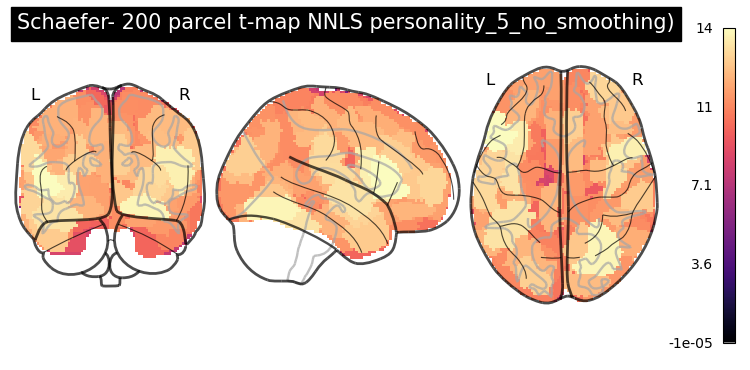

In [6]:
# Unthresholded t-map for visualization of psuedo F-scores against 1 
# ─── PARAMETERS ───────────────────────────────────────────────────────────
n_rois = 200
yeo_networks = 17
resolution_mm = 2
# fdr_alpha = 0.05     # threshold for p_fdr

# input CSV from group‐level t-test against F=1
group_csv = f"/Volumes/Passport/fmriprep/derivatives/RSA_stats/{STIMULUS_LABEL_SAVE_STRING}/multi_regression/group_results/group_F1_stats_with_FDR_NNLS_{model_key}{smoothing_setting}.csv"

# output map filename
out_nii  = f"{n_rois}_parcel_t_map_NNLS_{model_key}{smoothing_setting}.nii.gz"

# ─── 1) LOAD & THRESHOLD ─────────────────────────────────────────────────
gr = pd.read_csv(group_csv)
# grab the full list of t‐stats in parcel order
t_values = gr.sort_values("parcel_num")["t_stat"].tolist()
# threshold down to only the significant parcels
# thr = gr[gr["p_fdr"] < fdr_alpha]

# ─── 2) FETCH THE SCHAEFER ATLAS ─────────────────────────────────────
schaefer   = datasets.fetch_atlas_schaefer_2018(
    n_rois=n_rois,
    yeo_networks=yeo_networks,
    resolution_mm=resolution_mm
)
atlas_img  = nib.load(schaefer["maps"])
atlas_data = atlas_img.get_fdata().astype(int)

# sanity check
assert atlas_data.max() == n_rois

# ─── 3) BUILD THE 3D T-STAT MAP ──────────────────────────────────────────
t_map = np.zeros_like(atlas_data, dtype=float)
for _, row in gr.iterrows():
    pid    = int(row["parcel_num"])
    tstat  = float(row["t_stat"])
    t_map[atlas_data == pid] = tstat

# ─── 4) SAVE OUT NIfTI ───────────────────────────────────────────────────
out_dir = os.path.join(
    deriv_dir,
    "RSA_stats",
    STIMULUS_LABEL_SAVE_STRING,   # no {…}
    "multi_regression",           # no {…}
)
os.makedirs(out_dir, exist_ok=True)

out_nii = os.path.join(
    out_dir,
    f"{n_rois}parcel_t_map_NNLS_{model_key}{smoothing_setting}.nii.gz"
)
new_img = nib.Nifti1Image(t_map, atlas_img.affine, atlas_img.header)
nib.save(new_img, out_nii)
print("✅ Saved thresholded t-map →", out_nii)

# ─── 5) PLOT (GLASS BRAIN) ────────────────────────────────────────────────
plotting.plot_glass_brain(
    out_nii,
    # threshold =5.0,      # set t threshold for more or less conservative display
    cmap="magma",
    colorbar=True,
    title=f"Schaefer- {n_rois} parcel t-map NNLS {model_key}{smoothing_setting})"
)
plotting.show() 